In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from pathlib import Path

import torch
from torch import nn
import torch.nn.functional as F



import sbi 
from sbi import analysis
from sbi import utils as utils
from sbi.inference import NLE, NPE
from sbi.neural_nets import posterior_nn, likelihood_nn 



/export/home/vgiusepp/miniconda3/envs/sbi_ds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-02 09:56:01.347635: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 09:56:01.364572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746172561.383059 1189751 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746172561.388658 1189751 cuda

In [2]:
#normalization function
        
def normalize(dataset, is_observable = False, dataset_name=None):
    if dataset_name is not None:
        mean = np.load(f'./params_compressor/normalization_for_compressor_{dataset_name}.npz')['mean']
        std = np.load(f'./params_compressor/normalization_for_compressor_{dataset_name}.npz')['std']
    if is_observable:
        # the shape in this case is (N, N_particles, 6)
        dataset_original_shape = dataset.shape
        normalized_dataset = dataset.reshape(-1, dataset.shape[-1])
        normalized_dataset = (normalized_dataset - mean)/ (std + 1e-8) 
        normalized_dataset = normalized_dataset.reshape(dataset_original_shape)
    else:
        normalized_dataset = (dataset - mean)/ (std + 1e-8) 

    return normalized_dataset

In [ ]:
data_path = './data/data_NFW/'
pattern = re.compile(r"chunk_(\d+)\.npz")  # capture any number of digits
files = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) < 9500 and int(m.group(1)) > 0
)
theta_list, x_list, score_list = [], [], []

for f in files:
    data = np.load(f)
    theta_list.append(data["theta"])
    x_list.append(data["x"])
    
dataset_theta = np.array(theta_list,).reshape(-1, 5)
dataset_y = np.array(x_list, ).reshape(-1, 10_000, 6)


# #normalize the dataset
# dataset_theta = torch.tensor(normalize(dataset_theta, dataset_name='theta'))
# dataset_y = torch.tensor(normalize(dataset_y, is_observable=True, dataset_name='y'))

#rename
x = torch.tensor(dataset_y)
theta = torch.tensor(dataset_theta)

/tmp/ipykernel_1189751/259597820.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset_y)
/tmp/ipykernel_1189751/259597820.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(dataset_theta)


In [4]:
class DeepSetsEncoder(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=10):
        super().__init__()
        self.phi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [N, D] (unbatched) or [B, N, D] (batched)
        Returns:
            summary vector of shape [output_dim] or [B, output_dim]
        """
        if x.dim() == 2:
            # Unbatched input: [N_particles, 6]
            x_phi = self.phi(x)                  # [N, output_dim]
            summary = x_phi.mean(dim=0)          # [output_dim]
        elif x.dim() == 3:
            # Batched input: [B, N_particles, 6]
            B, N, D = x.shape
            x_phi = self.phi(x.view(-1, D))      # [B * N, output_dim]
            x_phi = x_phi.view(B, N, -1)         # [B, N, output_dim]
            summary = x_phi.mean(dim=1)          # [B, output_dim]
        else:
            raise ValueError(f"Expected shape (N, D) or (B, N, D), got {x.shape}")
        
        return summary

In [5]:
prior_min = [0.5, 1e3, 0.1, 5e11, 1.0]
prior_max = [10.0, 1e5, 1.0, 1.5e12, 20.0]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min, device='cuda'), high=torch.as_tensor(prior_max, device='cuda')
)


# instantiate the custom embedding_net
embedding_net_custom = DeepSetsEncoder().to(device='cuda')

# Instantiate the conditional neural density estimator
# neural_posterior = likelihood_nn(model="maf", embedding_net=embedding_net_custom)
neural_posterior = posterior_nn(model="maf", embedding_net=embedding_net_custom)
inference = NPE(prior=prior, density_estimator=neural_posterior, device='cuda')

density_estimator = inference.append_simulations(theta.to(device='cuda'), x.to(device='cuda')).train()
posterior = inference.build_posterior(density_estimator)


/export/home/vgiusepp/miniconda3/envs/sbi_ds/lib/python3.12/site-packages/sbi/neural_nets/factory.py:334: UserWarning: The passed embedding net will be moved to cpu for
                        constructing the net building function.
  check_net_device(embedding_net, "cpu", embedding_net_warn_msg),
/export/home/vgiusepp/miniconda3/envs/sbi_ds/lib/python3.12/site-packages/sbi/inference/trainers/npe/npe_base.py:158: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/export/home/vgiusepp/miniconda3/envs/sbi_ds/lib/python3.12/site-packages/sbi/inference/trainers/npe/npe_base.py:158: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 187 epochs.

In [ ]:
data_path = './data/data_NFW/'
pattern = re.compile(r"chunk_(\d+)\.npz")  # capture any number of digits
files = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) > 10_000 and int(m.group(1)) < 10_002
)
theta_list, x_list, score_list = [], [], []

for f in files:
    data = np.load(f)
    theta_list.append(data["theta"])
    x_list.append(data["x"])
    score_list.append(data["score"]) 
    
dataset_theta = np.array(theta_list,).reshape(-1, 5)
dataset_y = np.array(x_list, ).reshape(-1, 10_000, 6)


#normalize the dataset
# dataset_theta = torch.tensor(normalize(dataset_theta, dataset_name='theta'))
# dataset_y = torch.tensor(normalize(dataset_y, is_observable=True, dataset_name='y'))

#rename
x = torch.tensor(dataset_y)
theta = torch.tensor(dataset_theta)

true_parameter = theta[0].to(device='cuda')
x_observed = x[0].to(device='cuda')
samples = posterior.sample((5000,), x=x_observed.to(device='cuda'), show_progress_bars=True)


# create the figure
# fig, ax = analysis.pairplot(
#     samples.cpu().numpy(),
#     points=true_parameter.cpu().numpy(),
#     labels=["t_end", "Mtot_plummer", "a_plummer", "M_NFW", "r_s"],
#     limits=np.stack([prior_min, prior_max], axis=1),
#     fig_kwargs=dict(
#         points_colors="r",
#         points_offdiag={"markersize": 6},
#     ),
#     figsize=(5, 5),
# )


/tmp/ipykernel_1189751/893515729.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset_y)
/tmp/ipykernel_1189751/893515729.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(dataset_theta)
Drawing 5000 posterior samples:   0%|          | 0/5000 [03:23<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import pandas as pd

df_samples = pd.DataFrame(samples.cpu().numpy(), columns=["$t_{end}$", "$M_{plummer}$", "$a_{plummer}$", "$M_{NFW}$", "$r_s$"])
df_true = pd.DataFrame(true_parameter.cpu().numpy().reshape((1, 5)), columns=["$t_{end}$", "$M_{plummer}$", "$a_{plummer}$", "$M_{NFW}$", "$r_s$"])

Parameter $t_{end}$ in chain Posterior samples is not constrained


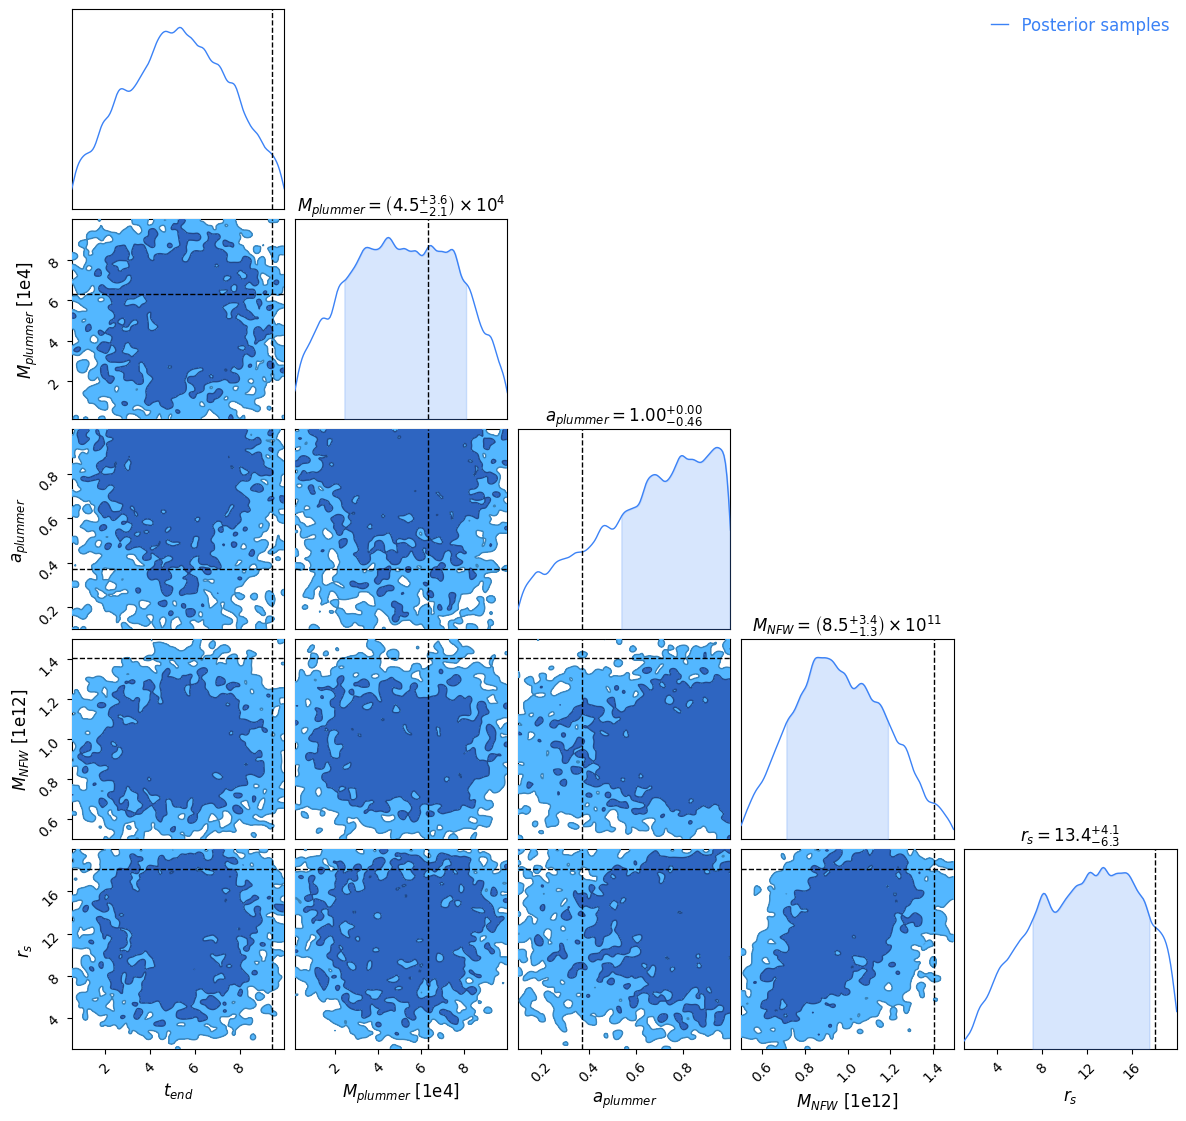

In [ ]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth, PlotConfig


c = ChainConsumer()
c.add_chain(Chain(samples=df_samples, name='Posterior samples'))
c.add_truth(Truth(location=df_true.to_dict('records')[0], name='True' ),)
c.set_plot_config(PlotConfig(show_legend=True))
fig = c.plotter.plot()
